# Seven segment digit classification

This notebook contains our development of several computer vision and deep learning programs to identify and classify numbers composed of seven segment digits in photos. 

We followed a 3 step methodology which is organised as follows:


  1. Extract LCD screen
  
  2. Extract each digit
  
  3. Classifiy digit per digit


For the first step (extracting LCD), we use angle detection. Within each photo, the angles the most to the left and right of the photo approximately correspond to each corner of the LCD screen.

For the second step, we considered a simple approach to crop out each digit individually out of the extracted LCD screen. We simply divide the LCD in different proportion segments. Proportions were reverse engineered to get the best approximate crop. 

The third and last step corresponds to the transfer learning part. We used the Mobilenet model pre-trained on the Imagenet dataset as a basis for our classifier. The crops are then passed to the downloaded model, for which we defreeze some layers to adapt to our case, seven segment digits being uncommon in datasets for model training. 

You will find below the code we developed following this methodology in order. 


## Mount drive to load and save data

In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


To be able to run this notebook, simply mount your drive with the chunk above and add the data folder to your drive

## Load packages

In [0]:
import logging
import shutil
import imutils
import glob
import os

import numpy as np
import pandas as pd
import math
import matplotlib
import matplotlib.pyplot as plt 
#matplotlib.use('agg')

import cv2
import skimage.filters as ft
import scipy.spatial as sp
from skimage.measure import label, regionprops
from PIL import Image, ImageEnhance 

import tensorflow as tf
from sklearn.model_selection import train_test_split
import keras.backend
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten
from keras.layers.core import Dropout, Activation
from keras.layers import BatchNormalization
from keras.layers import Dense,GlobalAveragePooling2D
from keras import regularizers
from keras.optimizers import Adam
from keras.utils import plot_model
from keras.callbacks import TensorBoard,EarlyStopping
from keras.backend.tensorflow_backend import set_session
from keras.applications import MobileNet
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


## Extracting LCD screen

### Extraction with angle identification

First we define a class which we can apply automatically to all our input images. Note that all the preprocessing is integrated directly in this class and applied to each photo to increase chances of correctly isolating the LCD.

In [0]:
class frameExtractor_3:

    def __init__(self, image=None, src_file_name=None, dst_file_name=None, return_image=False, output_shape =(400,100)):
        """
        Use this class to extract the frame/LCD screen from the image. This is our step 1 for image preprocessing.
        The final frame is extracted in grayscale.
        Note that it works for the "digital" case and can be used for the "analog" case, but it is more efficient on the "digital" case.
        :param image: RGB image (numpy array NxMx3) with a screen to extract. If image is None, the image will be extracted from src_filename
        :param src_file_name: filename to load the source image where the screen needs to be extracted (e.g. HQ_digital/0a07d2cff5beb0580bca191427e8cd6e1a0eb678.jpg)
        :param dst_file_name: filename to save the preprocessed image (e.g. HQ_digital_frame/0a07d2cff5beb0580bca191427e8cd6e1a0eb678.jpg
        :param return_image: a boolean, if True extractAndSave returns an image (np. array) / if False it just saves the image.
        :param output_shape: shape (in pxl) of the output image.
        """
        if image is None :
            self.image = cv2.imread(src_file_name)
        else :
            self.image = image
        self.dst_file_name = dst_file_name
        self.return_image = return_image
        self.output_shape = output_shape
        #self.raw_frame = None
        #self.frame = None
        #self.sliced_frame = None
        
    
    def our_max(self, i):   
      if len(i) == 0 :  
        total_max = np.reshape(np.array([1,1,2,20]),(2,2))
       
      if len(i) != 0 :
        col1 = i[:,1]
        col1_max = max(col1)
        total_max = i[np.where(col1 == col1_max)]
       
      if len(total_max) == 1: 
        added = np.reshape(np.array([2,20]),(1,2))
        total_max =np.append(total_max,added,axis = 0)
        
        return total_max[1]
      
      return total_max[0]
  
    
    def our_min(self, i):
      if len(i) == 0 :  
        total_min = np.reshape(np.array([1,1,2,20]),(2,2))
       
      if len(i) != 0 :
        col1 = i[:,1]
        col1_min = min(col1)
        total_min = i[np.where(col1 == col1_min)]
       
      if len(total_min) == 1: 
        added = np.reshape(np.array([1,10]),(1,2))
        total_min =np.append(total_min,added,axis = 0)
        return total_min[1]
 
      return total_min[1]

    def create_point(self, image,y,x,size_point=2):
    
      height, width, c = image.shape
      border_rect = (x-int(round(width/400)),y-int(round(width/400)))
      border_rect2 = (x+int(round(width/400)),y+int(round(width/400)))
      img = cv2.rectangle(image,border_rect,border_rect2,(0,250,0),3)
      
      return img
  
    def order_points(self, pts):
	# initialize a list of coordinates that will be ordered
	# such that the first entry in the list is the top-left,
	# the second entry is the top-right, the third is the
	# bottom-right, and the fourth is the bottom-left
      rect = np.zeros((4, 2), dtype = "float32")
 
	# the top-left point will have the smallest sum, whereas
	# the bottom-right point will have the largest sum
      s = pts.sum(axis = 1)
      rect[0] = pts[np.argmin(s)]
      rect[2] = pts[np.argmax(s)]
 
	# now, compute the difference between the points, the
	# top-right point will have the smallest difference,
	# whereas the bottom-left will have the largest difference
      diff = np.diff(pts, axis = 1)
      rect[1] = pts[np.argmin(diff)]
      rect[3] = pts[np.argmax(diff)]
	# return the ordered coordinates
      return rect
    
    def four_point_transform(self, image, pts):
	# obtain a consistent order of the points and unpack them
	# individually
      rect = self.order_points(pts)
      (tl, tr, br, bl) = rect
 
	# compute the width of the new image, which will be the
	# maximum distance between bottom-right and bottom-left
	# x-coordiates or the top-right and top-left x-coordinates
      widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
      widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
      maxWidth = max(int(widthA), int(widthB))
 
	# compute the height of the new image, which will be the
	# maximum distance between the top-right and bottom-right
	# y-coordinates or the top-left and bottom-left y-coordinates
      heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
      heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
      maxHeight = max(int(heightA), int(heightB))
 
	# now that we have the dimensions of the new image, construct
	# the set of destination points to obtain a "birds eye view",
	# (i.e. top-down view) of the image, again specifying points
	# in the top-left, top-right, bottom-right, and bottom-left
	# order
      dst = np.array([
		[0, 0],
		[maxWidth - 1, 0],
		[maxWidth - 1, maxHeight - 1],
		[0, maxHeight - 1]], dtype = "float32")
 
	# compute the perspective transform matrix and then apply it
      M = cv2.getPerspectiveTransform(rect, dst)
      warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
 
	# return the warped image
      return warped
  
    def remove_close_points(self, centroids,max_point,img,removal_parameter = 0.2):
      height, width, c = img.shape
      possible_points = []
      for i in centroids:
        if (np.abs(i[0]-max_point[0]) > removal_parameter*height):
          possible_points.append(i)
        
      possible_points = np.array(possible_points)  
      return possible_points
    
    
    def distance(self, pointA,pointB):
      
      dist = math.sqrt((pointA[0] - pointB[0])**2 + (pointA[1] - pointB[1])**2)
      return dist
  
    def get_degrees(self, segment1,segment2,segment3):
    #get angle between segment1 and 2
      radius = (segment1 * segment1 + segment2 * segment2 - segment3 * segment3)/(2.0 * segment1 * segment2)
      if radius > 1 :
        angle = 180 - math.degrees(math.acos(radius - 2 ))
      elif radius < -1 : 
        angle = 180 - math.degrees(math.acos(radius + 2 ))
      else :
        angle = math.degrees(math.acos(radius))
    
      return angle
  
    def point_orderer(self, rect4):
      if rect4[0][1] < rect4[1][1] :
        A = rect4[0]
        B = rect4[1]
      
      else :
        A = rect4[1]
        B = rect4[0]
        
      if rect4[2][1] < rect4[3][1] :
        C = rect4[3]
        D = rect4[2]
        
      else :
        C = rect4[2]
        D = rect4[3]   
        
      return A,B,C,D
  
  
    def correct_point(self, opposed,sided1,sided2,correct_point):
      
      correct_point[0] = sided1[0] + sided2[0] - opposed[0]
      correct_point[1] = sided1[1] + sided2[1] - opposed[1]
      
      return correct_point
    
    
    def crop_crop_strategy(self, A,B,C,D, tolerance, ratio_tolerance):

    #compute sides
      AB = self.distance(A,B)
      BC = self.distance(B,C)
      CD = self.distance(C,D)
      AD = self.distance(D,A)
    
    #compute diags
      AC = self.distance(A,C)
      BD = self.distance(B,D)
    
      Angle_A = self.get_degrees(AB,AD,BD)
      Angle_B = self.get_degrees(AB,BC,AC)
      Angle_C = self.get_degrees(BC,CD,BD)
      Angle_D = self.get_degrees(AD,CD,AC)
    
      ratio_A = AD/AB*abs(Angle_A-90)/100
      ratio_B = BC/AB*abs(Angle_B-90)/100
      ratio_C = BC/CD*abs(Angle_C-90)/100
      ratio_D = AD/CD*abs(Angle_D-90)/100
    
      if abs(Angle_A - Angle_C) > tolerance:

        if abs(Angle_A -90) > abs(Angle_C - 90):
            
            ## scenario corret A
          if abs(ratio_A-ratio_tolerance) > abs(ratio_B-ratio_tolerance) and abs(ratio_A-ratio_tolerance) > abs(ratio_D-ratio_tolerance): 
            A = self.correct_point(C,B,D,A)

        else :
          ## scenario correect C
          if abs(ratio_C-ratio_tolerance) > abs(ratio_B-ratio_tolerance) and abs(ratio_C-ratio_tolerance) > abs(ratio_D-ratio_tolerance)  :
            C = self.correct_point(A,B,D,C)
            
      if abs(Angle_B - Angle_D) > tolerance:
      
        if abs(Angle_B -90) > abs(Angle_D - 90):
            
            ## scenario corret B
          if abs(ratio_B-ratio_tolerance) > abs(ratio_C-ratio_tolerance) and abs(ratio_B-ratio_tolerance) > abs(ratio_A-ratio_tolerance):
            B = self.correct_point(D,A,C,B)
            
        else :
            ## scenario correect D
          if abs(ratio_D-ratio_tolerance) > abs(ratio_C-ratio_tolerance) and abs(ratio_D-ratio_tolerance) > abs(ratio_A-ratio_tolerance) :
            D = self.correct_point(B,A,C,D)

            
        return A,B,C,D
  
    def crop_correcter(self, rect4, tolerance = 0, ratio_tolerance = 0):
    
      A,B,C,D = self.point_orderer(rect4)
    
      A,B,C,D = self.crop_crop_strategy(A,B,C,D,tolerance = tolerance, ratio_tolerance = ratio_tolerance)

      return A,B,C,D
    
    def first_cropping(self, resize_width = 70,crop_crop = 0.05):
      
      image = self.image
    
      first_height, first_width, c = image.shape
      #Adding borders for better angle selection
    
      cropping_width = int(round(crop_crop*first_width))
      cropping_height = int(round(crop_crop*first_height))
    
      image = image[cropping_height:first_height-cropping_height, 
                  cropping_width:first_width-cropping_width]
      img = cv2.copyMakeBorder(np.array(image), 0, 0, 50, 50, cv2.BORDER_CONSTANT, value = [0,0,0] )
      cropped = cv2.copyMakeBorder(np.array(image), 0, 0, 50, 50, cv2.BORDER_CONSTANT, value = [0,0,0] )
    
    
      origin_height, origin_width, c = img.shape
      transformation_ratio = origin_width/resize_width 
      img = imutils.resize(img, width = resize_width)
#     light preprocessing: grey
    
      gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    ##passing in float32 for function corner harris
      gray = np.float32(gray)
      
    #### OPTI PARA #######################################################################"""
      dst = cv2.cornerHarris(gray,2,3,0.001)    
    #result is dilated for marking the corners, not important
      dst = cv2.dilate(dst,None)
    
    # Threshold for an optimal value, it may vary depending on the image.
    # dst = metric of cornerhood
      img[dst>0.02*dst.max()]=[0,0,255]
    
      pointed = img
      dst = np.uint8(dst)

#     identify where the red (0,0,255) points are
      coord = np.where(np.all(img == (0, 0, 255), axis=-1))    
      centroids = np.array(coord).T
    
      max_left = self.our_min(centroids)
      max_right = self.our_max(centroids)
    
      possible_points_left =  self.remove_close_points(centroids,max_left,img)
      possible_points_right = self.remove_close_points(centroids,max_right,img)
        
      possible_points_right = np.array(possible_points_right)
    
      second_max_left = self.our_min(possible_points_left)
      second_max_right = self.our_max(possible_points_right)
#     print('max left:' + str(max_left))


        
      rect2 = np.zeros((4, 2), dtype = "float32")
      rect2[0] = max_left*transformation_ratio
      rect2[1] = second_max_left*transformation_ratio
      rect2[2] = max_right*transformation_ratio
      rect2[3] = second_max_right*transformation_ratio

    
      rect4 = np.zeros((4, 2), dtype = "float32")
      rect4[:,0] = rect2[:,1]
      rect4[:,1] = rect2[:,0]
    
      A,B,C,D = self.crop_correcter(rect4)
      rect2[0] = A
      rect2[1] = B
      rect2[2] = C
      rect2[3] = D

    
    

      warped = self.four_point_transform(cropped, rect4)

      return warped
  
    def extractAndSaveFrame(self):
        """
        Use this method to
                1. detect and select the frame/screen.
                2. preprocessing to only keep numbers (and remove noise).
                3. slice the frame to only keep integer part.
                4. save the sliced frame in dst_file_name.
        :return: the extracted frame (np.array) if it was specified when instantiating the class.
        """
        final = self.first_cropping()
        cv2.imwrite(self.dst_file_name, final)
        if self.return_image:
            return final
        else:
            return




We then apply the class to all our input photos and save the extracted LCD images to the Datasets_frames folder (Check your directories). We check for failed extractions for each quality level of photos (printed with the "fail" list)

In [0]:
if __name__ == "__main__":

    if os.path.exists('Datasets_frames/'):
        shutil.rmtree('Datasets_frames/')
        os.makedirs('Datasets_frames/')
    else:
        os.makedirs('Datasets_frames/')

    fail = [0, 0, 0]

    for file in glob.glob('/content/drive/My Drive/Data_Analog_Digital/HQ_digital/*jpg'):

        try:
            f = frameExtractor_3(image=None,
                     src_file_name=file,
                     dst_file_name='Datasets_frames/' + str(file).split('/')[-1],
                     return_image=False,
                     output_shape=(400, 100))
            f.extractAndSaveFrame()
        except:
            fail[0] += 1

    for file in glob.glob('/content/drive/My Drive/Data_Analog_Digital/LQ_digital/*jpg'):
        try:
            f = frameExtractor_3(image=None,
                     src_file_name=file,
                     dst_file_name='Datasets_frames/' + str(file).split('/')[-1],
                     return_image=False,
                     output_shape=(400, 100))
            f.extractAndSaveFrame()
        except:
            fail[1] += 1

    for file in glob.glob('/content/drive/My Drive/Data_Analog_Digital/MQ_digital/*jpg'):
        try:
            f = frameExtractor_3(image=None,
                     src_file_name=file,
                     dst_file_name='Datasets_frames/' + str(file).split('/')[-1],
                     return_image=False,
                     output_shape=(400, 100))
            f.extractAndSaveFrame()
        except:
            fail[2] += 1

    print(fail)

[4, 3, 0]


Now that we have extracted the LCD from each photo, we can either follow the first or second methodology briefly described above. 

## Individual digit detection

> **1.** We need to seperate each digit within the cropped out LCD screen. To do this we simply divide the extracted LCD in four equal segments (cadran 1, 2, 3, 4). We then save each cropped digit in a folder corresponding to its digit based on the csv relating this information.

> **2.** We then need to generate a dataset (array form) to pass to our neural net for training.

> **3.**  




### 1. Digit detection

We start by constructing a class which we can pass automatically to all the LCD images we extracted.
To extract digits we segment our cropped photos according to certain proportions. We can also go through the same process without taking into account proportions, but this only works if the digits before the decimal are extracted (with frame_extractor() instead of frame_extractor_2()).

In [0]:
class cutDigits_3:

    def __init__(self, image=None, src_file_name=None, dst_folder_name='Test_Datasets_digits', labels=None):
        """
        The aim of this class is to extract digits from the frame-only preprocessed image.
        We to delimit digits by bounding boxes.
        We tried several approaches, but we present here the most successful one, a "dummy" yet efficient approach.
        :param image: RGB image (numpy array NxMx3) of a SLICED SCREEN. If image is None, the image will be extracted from src_filename
        :param src_file_name: filename of a SLICED SCREEN to load the source image (e.g. HQ_digital_preprocessing/0a07d2cff5beb0580bca191427e8cd6e1a0eb678.jpg)
        :param dst_folder_name: home FOLDERname where to save the extracted digits.
        :param last_digit: int, the number of digits you want to extract starting from the left (0 = no digits / 4 = all four digits).
        :param labels: list, list of labels corresponding to the image, e.g. if th image shows 123.45, the labels will be ['x',1,2,3].
        """
        if image is None :
            self.image = cv2.imread(src_file_name)
        else:
            self.image = image
        self.src_file_name = src_file_name
        self.dst_folder_name = dst_folder_name
        #self.last_digit=last_digit
        self.labels = labels

        #self.box_size = None
    
    def light_enhancement(self, image, light_factor = 1.7):
      
      im = Image.fromarray(image)
      enhancer = ImageEnhance.Brightness(im)
      enhanced_img = enhancer.enhance(light_factor)
      enhanced_im = np.asarray(enhanced_img)
      
      return(enhanced_im)
    
    
    def preprocess(self, image):
      
      gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
      gamma = self.light_enhancement(gray, light_factor = 3)
      blurred = cv2.medianBlur(gamma, 3)
      cleaned = cv2.bilateralFilter(blurred, 9, 75, 75)
      equal = cv2.equalizeHist(cleaned)
      thresh = cv2.threshold(equal, 45, 255, cv2.THRESH_BINARY_INV)[1]
      eroded = cv2.erode(thresh, np.ones((4,4),np.uint8), iterations=1)
      dilated = cv2.dilate(eroded, np.ones((6,6),np.uint8), iterations=2)
      frame = dilated
      
      return frame
    

    def grayish(self):
      
      gray = self.image
      gray_preproc = self.preprocess(gray)
      
      h = gray.shape[0]
      w = gray.shape[1]
      t = 0.4*w
  
            
      crop_img1 = gray_preproc[int(0.05*h):h, int(0*w):int(0.15*w)]
  
      crop_img2 = gray_preproc[int(0.05*h):h, int(0.15*w):int(0.35*w)]
      #crop_img2 = gray[int(0.05*h):h, int(0.15*w):int(0.3*w)]

      crop_img3 = gray_preproc[int(0.05*h):h, int(0.3*w):int(0.5*w)]
      #crop_img3 = gray[int(0.05*h):h, int(0.3*w):int(0.5*w)]

      crop_img4 = gray_preproc[int(0.05*h):h, int(0.5*w):int(0.7*w)]
      #crop_img4 = gray[int(0.05*h):h, int(0.5*w):int(0.6*w)]

      
      crops = [crop_img1, crop_img2, crop_img3, crop_img4]
      
      
  
    # These are decimals, we don't care about them.
  
    #crop_img5 = gray[int(0.05*h):h, int(0.6*w):int(0.8*w)]
    #crop_img6 = gray[int(0.05*h):h, int(0.75*w):int(0.95*w)]
  
      return crops

    def save_to_folder(self) :
        """
        Use this method to save the extracted bounding boxes.
        """
        if self.dst_folder_name is None :
            return
          
        boxes = self.grayish()

        for i in range(len(boxes)):
          
            if self.labels :
                box = boxes[i]
                label = self.labels[i]
                src_file_name = self.src_file_name.split('/')[-1].split('.')[0]
                dst_file_name = 'Datasets_digits/%s/%s_%s.jpg' % (label, src_file_name, str(i))
                cv2.imwrite(dst_file_name, box)
                
            else:
                pass

We then apply this class to all the frames extracted and saved in the Datasets_frames folder and save the individual digits in the Datasets_digits folder.

In [0]:
if __name__ == "__main__":
    
    
    if os.path.exists('Datasets_digits/'):
        shutil.rmtree('Datasets_digits/')
        for i in range(0,11):
            os.makedirs('Datasets_digits/%i' %i)
    else:
        for i in range(0,11):
            os.makedirs('Datasets_digits/%i' %i)

    # TODO: check why they fail

    fail = 0

    df = []
    # NB: These 3 datasets were made with Excel
    
    suffix = "csv"
    csv_directory = "/content/drive/My Drive/Data_Analog_Digital/"
    csv_files = [i for i in os.listdir(csv_directory) if i.endswith( suffix )]
    df = []
    for i in range(len(csv_files)):
        data = pd.read_csv(csv_directory +csv_files[i], sep=';')
        df.append(data)
            
    df = pd.concat(df, axis=0)
    df = df.replace("X", 10)

    for i in range(df.shape[0]):
        line = df.iloc[i]
        labels = [str(line.cadran_1), str(line.cadran_2), str(line.cadran_3), str(line.cadran_4)]
        file_name = line.image
        src_file_name = "/content/Datasets_frames/%s" % file_name
        #print(line,"\n",labels,"\n",file_name,"\n",src_file_name)
        
        try:
          cutter = cutDigits_3(src_file_name = src_file_name, labels=labels)
            #cutter.get_bounding_box_dummy()
          cutter.save_to_folder() 
        except: 
          fail +=1
          
    print(fail)


92


All digits being cropped, preprocessed and associated to the correct label we can now start the dataset generation to be passed to the neural net (array form)

# Transfer learning

We decided to consider transfer learning for digit classification. We compare results of the classifier with and without feature augmentation to benchmark our accuracy. 

## 1. With feature augmentation


**Function**: train_transfer_learning

This function calls the training of the neural network (NN).
The neural network has been trained on the ImageNet dataset.
We use transfer learning to use this powerful pre-trained NN, and rettrain only parts of it.
In addition, we add a few layers to the existing network
We trained two versions:
1) with feature augmentation
2) without feature augmentation
"""

In [0]:
for i in range(11):
  folder = str(i)+"/"
  new_dir = "/content/Validation_Datasets_digits/"+str(folder)
  old_dir = "/content/Datasets_digits/"+str(folder)

  for root, directories, files in os.walk(old_dir, topdown=True):
    i = 0 

    if os.path.exists(new_dir):
      shutil.rmtree(new_dir)

    if not os.path.exists(new_dir):
      os.makedirs(new_dir)

    for file in files:
      i+=1
      shutil.move(old_dir+str(file), 
              str(new_dir)+str(file))
      if i == 30:
        break
print("done")

done


In [0]:
def train_transfer_learning():
  #import MobileNet for transfer learning:
  base_model = MobileNet(weights='imagenet',include_top=False) #imports the mobilenet model and discards the last 1000 neuron layer.
  x=base_model.output
  x=GlobalAveragePooling2D()(x)
  x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
  x=Dense(1024,activation='relu')(x) #dense layer 2
  x=Dense(512,activation='relu')(x) #dense layer 3
  #we classify into 10 digts, so we need 10 neurons:
  preds=Dense(11,activation='softmax')(x) #final layer with softmax activation
  #generate model based on architecture provided:
  model=Model(inputs=base_model.input,outputs=preds)
  #activate transfer learning
  for layer in model.layers[:75]:
    layer.trainable=False
  #defreeze layers for re-training:
  for layer in model.layers[75:]:
    layer.trainable=True
  (train_generator,val_generator) = prepare_images_for_algorithm()
 #train the model:
  model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
 # Adam optimizer
 # loss function will be categorical cross entropy
 # evaluation metric will be accuracy
  step_size_train=train_generator.n//train_generator.batch_size
  model_out = model.fit_generator(generator=train_generator,
                     validation_data=val_generator,
                    steps_per_epoch=step_size_train,
                    epochs=40)
  return model_out

def prepare_images_for_algorithm():
 #put images into right format:
  train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input,
                                  rotation_range=20,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  horizontal_flip=True
                                 ) #included in our dependencies
  test_datagen=ImageDataGenerator(preprocessing_function=preprocess_input
                                  #rotation_range=20,
                                  #width_shift_range=0.2,
                                  #height_shift_range=0.2,
                                  #horizontal_flip=True
                                ) #included in our dependencies
  train_generator=train_datagen.flow_from_directory("/content/Datasets_digits",
                                                  target_size=(228,228),
                                                  color_mode='rgb',
                                                  batch_size=40,
                                                  class_mode='categorical',
                                                  shuffle=True)
  val_generator=test_datagen.flow_from_directory("/content/Validation_Datasets_digits",
                                                  target_size=(228,228),
                                                  color_mode='rgb',
                                                  batch_size=40,
                                                  class_mode='categorical',
                                                  shuffle=True)
  return(train_generator,val_generator)

In [0]:
model_with_augmentation = train_transfer_learning()

/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '



17227776/17225924 [==============================] - 2s 0us/step
Found 2734 images belonging to 11 classes.
Found 330 images belonging to 11 classes.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/40
68/68 [==============================] - 40s 589ms/step - loss: 1.5297 - acc: 0.5316 - val_loss: 2.5974 - val_acc: 0.2182
Epoch 2/40
68/68 [==============================] - 37s 543ms/step - loss: 1.2049 - acc: 0.6376 - val_loss: 3.6051 - val_acc: 0.2061
Epoch 3/40
68/68 [==============================] - 37s 541ms/step - loss: 1.0826 - acc: 0.6723 - val_loss: 1.8792 - val_acc: 0.3818
Epoch 4/40
68/68 [==============================] - 37s 542ms/step - loss: 1.0523 - acc: 0.6943 - val_loss: 2.1832 - val_acc: 0.3061
Epoch 5/40
68/68 [==============================] - 37s 541ms/step - loss: 1.0242 - acc: 0.7060 - val_loss: 2.7020 - val_acc: 0.1909
Epoch 6/40
68/68 [==============================] - 37s 540ms/step - loss: 0.9750 - acc: 

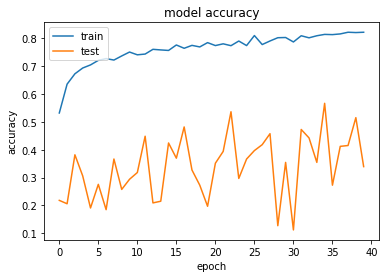

In [0]:
# summarize history for accuracy
plt.plot(model_with_augmentation.history['acc'])
plt.plot(model_with_augmentation.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

It may be that the model is better off without data augmentation which we check for below. 

In [0]:
model_with_augmentation

NameError: ignored

## 2. without feature augmentation

In [0]:

"""
-------------------------------------------------------
Function: train_transfer_learning
-------------------------------------------------------
This function calls the training
"""
def train_transfer_learning():
  #import MobileNet for transfer learning:

  base_model = MobileNet(weights='imagenet',include_top=False) #imports the mobilenet model and discards the last 1000 neuron layer.

  x=base_model.output
  x=GlobalAveragePooling2D()(x)
  x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
  x=Dense(1024,activation='relu')(x) #dense layer 2
  x=Dense(512,activation='relu')(x) #dense layer 3

  #we classify into 10 digts, so we need 10 neurons:
  preds=Dense(11,activation='softmax')(x) #final layer with softmax activation
  
  #generate model based on architecture provided:
  model=Model(inputs=base_model.input,outputs=preds)
  
  #activate transfer learning
  for layer in model.layers[:75]:
      layer.trainable=False
  #defreeze layers for re-training:
  for layer in model.layers[75:]:
      layer.trainable=True
      
  train_generator,val_generator = prepare_images_for_algorithm()
  
  #train the model:
  model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
  # Adam optimizer
  # loss function will be categorical cross entropy
  # evaluation metric will be accuracy

  step_size_train=train_generator.n//train_generator.batch_size
  trained_model = model.fit_generator(generator=train_generator,
                      validation_data=val_generator,
                     steps_per_epoch=step_size_train,
                     epochs=20)
  return trained_model

 
def prepare_images_for_algorithm():
  #put images into right format:
  train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input,
                                   #rotation_range=20,
                                   #width_shift_range=0.2,
                                   #height_shift_range=0.2,
                                   #horizontal_flip=True
                                  ) #included in our dependencies
  test_datagen=ImageDataGenerator(preprocessing_function=preprocess_input,
                                   #rotation_range=20,
                                   #width_shift_range=0.2,
                                   #height_shift_range=0.2,
                                   #horizontal_flip=True
                                 ) #included in our dependencies


  train_generator=train_datagen.flow_from_directory("/content/Datasets_digits",
                                                   target_size=(228,228),
                                                   color_mode='rgb',
                                                   batch_size=40,
                                                   class_mode='categorical',
                                                   subset='training'
                                                   #shuffle=True
                                                   )

  val_generator=train_datagen.flow_from_directory("/content/Datasets_digits",
                                                   target_size=(228,228),
                                                   color_mode='rgb',
                                                   batch_size=40,
                                                   class_mode='categorical',
                                                   subset='validation'
                                                   #shuffle=True
                                                )
  
  return(train_generator,val_generator)

In [0]:
model = train_transfer_learning()

/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '



17227776/17225924 [==============================] - 1s 0us/step
Found 3064 images belonging to 11 classes.
Found 0 images belonging to 11 classes.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/20
76/76 [==============================] - 16s 212ms/step - loss: 1.3744 - acc: 0.6012
Epoch 2/20
76/76 [==============================] - 10s 131ms/step - loss: 0.9499 - acc: 0.7275
Epoch 3/20
76/76 [==============================] - 10s 131ms/step - loss: 0.7975 - acc: 0.7745
Epoch 4/20
76/76 [==============================] - 10s 131ms/step - loss: 0.7128 - acc: 0.7869
Epoch 5/20
76/76 [==============================] - 10s 131ms/step - loss: 0.6074 - acc: 0.8198
Epoch 6/20
76/76 [==============================] - 10s 131ms/step - loss: 0.5075 - acc: 0.8518
Epoch 7/20
76/76 [==============================] - 10s 131ms/step - loss: 0.4479 - acc: 0.8695
Epoch 8/20
76/76 [==============================] - 10s 131ms/step - loss: 0.4235 - 

Now that we have trained our CNN we can start making predictions for the test set.

## TEST-SET GENERATION

We first must go through the same process of extracting, cropping and pre-processing all the images before making prediction. 

Below is a class function re-adapted to apply the digit cropping part to a folder containing photos without labels attached. 

In [0]:
class cutDigits_4:

    def __init__(self, image=None, src_file_name=None, dst_folder_name='Test_Datasets_digits', labels=None):
        """
        The aim of this class is to extract digits from the frame-only preprocessed image.
        We to delimit digits by bounding boxes.
        We tried several approaches, but we present here the most successful one, a "dummy" yet efficient approach.
        :param image: RGB image (numpy array NxMx3) of a SLICED SCREEN. If image is None, the image will be extracted from src_filename
        :param src_file_name: filename of a SLICED SCREEN to load the source image (e.g. HQ_digital_preprocessing/0a07d2cff5beb0580bca191427e8cd6e1a0eb678.jpg)
        :param dst_folder_name: home FOLDERname where to save the extracted digits.
        :param last_digit: int, the number of digits you want to extract starting from the left (0 = no digits / 4 = all four digits).
        :param labels: list, list of labels corresponding to the image, e.g. if th image shows 123.45, the labels will be ['x',1,2,3].
        """
        if image is None :
            self.image = cv2.imread(src_file_name)
        else:
            self.image = image
        self.src_file_name = src_file_name
        self.dst_folder_name = dst_folder_name
        #self.last_digit=last_digit
        self.labels = labels

        #self.box_size = None
    
    def light_enhancement(self, image, light_factor = 1.7):
      
      im = Image.fromarray(image)
      enhancer = ImageEnhance.Brightness(im)
      enhanced_img = enhancer.enhance(light_factor)
      enhanced_im = np.asarray(enhanced_img)
      
      return(enhanced_im)
    
    
    def preprocess(self, image):
      
      gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
      gamma = self.light_enhancement(gray, light_factor = 3)
      blurred = cv2.medianBlur(gamma, 3)
      cleaned = cv2.bilateralFilter(blurred, 9, 75, 75)
      equal = cv2.equalizeHist(cleaned)
      thresh = cv2.threshold(equal, 45, 255, cv2.THRESH_BINARY_INV)[1]
      eroded = cv2.erode(thresh, np.ones((4,4),np.uint8), iterations=1)
      dilated = cv2.dilate(eroded, np.ones((6,6),np.uint8), iterations=2)
      frame = dilated
      
      return frame
    

    def grayish(self):
      
      gray = self.image
      gray_preproc = self.preprocess(gray)
      
      h = gray.shape[0]
      w = gray.shape[1]
      t = 0.4*w
  
            
      crop_img1 = gray_preproc[int(0.05*h):h, int(0*w):int(0.15*w)]
  
      crop_img2 = gray_preproc[int(0.05*h):h, int(0.15*w):int(0.35*w)]
      #crop_img2 = gray[int(0.05*h):h, int(0.15*w):int(0.3*w)]

      crop_img3 = gray_preproc[int(0.05*h):h, int(0.3*w):int(0.5*w)]
      #crop_img3 = gray[int(0.05*h):h, int(0.3*w):int(0.5*w)]

      crop_img4 = gray_preproc[int(0.05*h):h, int(0.5*w):int(0.7*w)]
      #crop_img4 = gray[int(0.05*h):h, int(0.5*w):int(0.6*w)]

      
      crops = [crop_img1, crop_img2, crop_img3, crop_img4]
      
      
  
    # These are decimals, we don't care about them.
  
    #crop_img5 = gray[int(0.05*h):h, int(0.6*w):int(0.8*w)]
    #crop_img6 = gray[int(0.05*h):h, int(0.75*w):int(0.95*w)]
  
      return crops

    def save_to_folder(self) :
        """
        Use this method to save the extracted bounding boxes.
        """
        if self.dst_folder_name is None :
            return
          
        boxes = self.grayish()

        for i in range(len(boxes)):
          
            if self.labels :
                box = boxes[i]
                label = self.labels[i]
                src_file_name = self.src_file_name.split('/')[-1].split('.')[0]
                dst_file_name = 'Test_Datasets_digits/%s/%s_%s.jpg' % (label, src_file_name, str(i))
                cv2.imwrite(dst_file_name, box)
                
            else:
                pass

We start by applying the frame extraction method:


In [0]:
if __name__ == "__main__":

    if os.path.exists('Test_Datasets_frames/'):
        shutil.rmtree('Test_Datasets_frames/')
        os.makedirs('Test_Datasets_frames/')
    else:
        os.makedirs('Test_Datasets_frames/')

    fail = [0, 0, 0]

    for file in glob.glob('/content/drive/My Drive/Test_Data_Analog_Digital/HQ_digital_test/*jpg'):

        try:
            f = frameExtractor_3(image=None,
                     src_file_name=file,
                     dst_file_name='Test_Datasets_frames/' + str(file).split('/')[-1],
                     return_image=False,
                     output_shape=(400, 100))
            f.extractAndSaveFrame()
        except:
            fail[0] += 1

    for file in glob.glob('/content/drive/My Drive/Test_Data_Analog_Digital/LQ_digital_test/*jpg'):
        try:
            f = frameExtractor_3(image=None,
                     src_file_name=file,
                     dst_file_name='Test_Datasets_frames/' + str(file).split('/')[-1],
                     return_image=False,
                     output_shape=(400, 100))
            f.extractAndSaveFrame()
        except:
            fail[1] += 1

    for file in glob.glob('/content/drive/My Drive/Test_Data_Analog_Digital/MQ_digital_test/*jpg'):
        try:
            f = frameExtractor_3(image=None,
                     src_file_name=file,
                     dst_file_name='Test_Datasets_frames/' + str(file).split('/')[-1],
                     return_image=False,
                     output_shape=(400, 100))
            f.extractAndSaveFrame()
        except:
            fail[2] += 1

    print(fail)
print("done")

[0, 2, 0]
done


We then proceed to crop the digits with the adapted class:

In [0]:
if __name__ == "__main__":
    
    
    if os.path.exists('Test_Datasets_digits/'):
        shutil.rmtree('Test_Datasets_digits/')
        for i in range(1,5):
            os.makedirs('Test_Datasets_digits/%i' %i)
    else:
        for i in range(1,5):
            os.makedirs('Test_Datasets_digits/%i' %i)

    # TODO: check why they fail

    fail = 0
    
    labels = [1,2,3,4]
    fail = 0
  
    for file in glob.glob('/content/Test_Datasets_frames/*jpg'):        
      try:
        cutter = cutDigits_4(src_file_name = file, labels=labels)
              #cutter.get_bounding_box_dummy()
        cutter.save_to_folder() 
      except:

        fail +=1

    print(fail)


0


We can now move on to predicting every digit individually to reconstruct the final number from the photo.

## Make prediction

In [0]:
from itertools import compress

folder_1 = sorted(glob.glob("/content/Test_Datasets_digits/1/*jpg"))
folder_2 = sorted(glob.glob("/content/Test_Datasets_digits/2/*jpg"))
folder_3 = sorted(glob.glob("/content/Test_Datasets_digits/3/*jpg"))
folder_4 = sorted(glob.glob("/content/Test_Datasets_digits/4/*jpg"))

folder_global = []
folder_global = [folder_1,folder_2,folder_3,folder_4]

final_pred_list = []
pic_name_list = []
number_pred_str = ""
for num_picture in range(len(folder_1)):
  count = 0
  for folder in folder_global:
    pic_name = str(folder[num_picture]).replace('_0','').replace('_1','').replace('_2','').replace('_3','').split('/')[-1]
    line = df.loc[df['image'] == pic_name].used_liter.item()
    count = count + 1
    
    img = cv2.imread(folder[num_picture])
    img2 = cv2.resize(img,(228,228))
    img3 = np.reshape(img2,(1,228,228,3))

    pred = (model.model.predict(img3))

    max_prob = max(pred[0][:])
    ind = (pred[0][:] == max_prob)

    
    prediction_list = ["0","1","X","2","3","4","5","6","7","8","9"]
    prediction_str = str(list(compress(prediction_list,ind))[0])
    if count == 1:
      prediction_str = "X"
    number_pred_str = number_pred_str + prediction_str
    number_pred_list.append(prediction_str)
    pic_name = str(folder[num_picture]).replace('_0','').replace('_1','').replace('_2','').replace('_3','').split('/')[-1]
    
    
    
    if count == 4:
      final_pred_list.append(number_pred_str)
      number_pred_str = ""
      pic_name_list.append(pic_name)
    
    

In [0]:
RESULT = pd.DataFrame()
RESULT["prediction"] = final_pred_list
RESULT["file"] = folder_1

RESULT.head()

,prediction,file
0,X5X5,/content/Test_Datasets_digits/1/00b527335f956f...
1,X515,/content/Test_Datasets_digits/1/00e22973fdbc19...
2,X266,/content/Test_Datasets_digits/1/00f35ec57ceabe...
3,XX16,/content/Test_Datasets_digits/1/00f531ce72874d...
4,XX55,/content/Test_Datasets_digits/1/02b292a500dfb9...
5,XX55,/content/Test_Datasets_digits/1/04dc6be4599a36...
6,X151,/content/Test_Datasets_digits/1/0a008e3b1506c5...
7,XX56,/content/Test_Datasets_digits/1/0a0216c77785d9...
8,X256,/content/Test_Datasets_digits/1/0a07d2cff5beb0...
9,X115,/content/Test_Datasets_digits/1/0a1e1c676aa31a...


Above should appear a dataframe containing the prediction for every photo within your dedicated test folder, with the according directory to each of them.